# Lab Two - Exploring Image Data
### Tommy Greim

## Business Understanding

## Data Preperation

In [2]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import glob

generalDir = '/home/tommy/Documents/College/Machine Learning/MachineLearningNotebooks/Labs/data/disaster_data_conv/'
folders = ['fires', 'flood', 'non_damage']
#Similar to https://stackoverflow.com/questions/26392336/importing-images-from-a-directory-python-to-list-or-dictionary
images = []
dmgTruth = []
# Populates two seperate lists:
    # images, list of row vectors
    # dmgTruth, list of truth values
# images will be converted to a nparray later
for fol in folders:
    for filePath in glob.glob(generalDir + fol + '/*.jpg'):
        newImg = Image.open(filePath).convert('L')
        imgArr = np.array(newImg)
        imgRow = imgArr.flatten()
        images.append(imgRow)
        dmgTruth.append(fol)


In [3]:
import random

#Shuffles both the image vectors and allow their corresponding labels.
tempZip = list(zip(images, dmgTruth))
random.shuffle(tempZip)
images, dmgTruth = zip(*tempZip)

#This process converts images and dmgTruth to tuples, so we need to convert them back
#For images, from tuple to nparray
images = np.expand_dims(list(images), -1)
#For dmgTruth, from tuple to list
dmgTruth = list(dmgTruth)

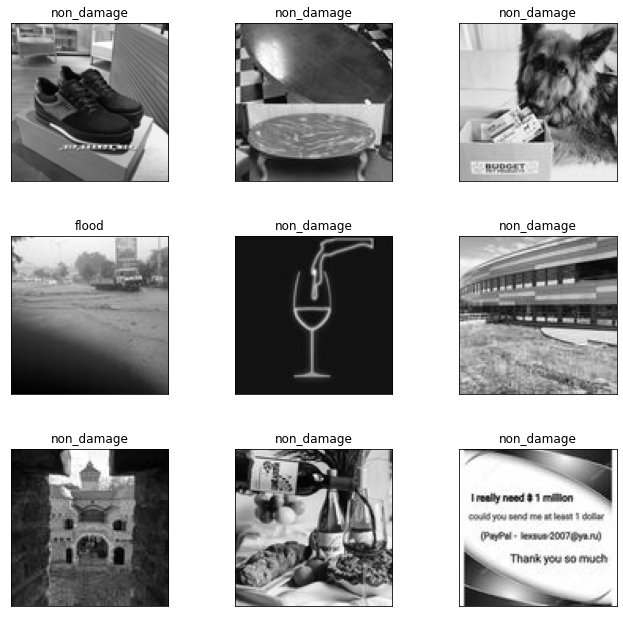

In [4]:
#Shamelessly lifted from the 'Dimension Reduction and Images' notebook
def plot_gallery(img, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(3 * n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(img[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(images, dmgTruth, 100, 100, n_row = 3, n_col = 3)

In [5]:
# Dividing both the images and truth into test and train data.
cutoff = int(0.75 * len(images))
trainImg = images[0:cutoff]
testImg = images[cutoff:]
trainTruth = dmgTruth[0:cutoff]
testTruth = dmgTruth[cutoff:]

trainImg = trainImg.reshape(int(0.75 * len(images)), 10000)
testImg = testImg.reshape(int(0.25 * len(images)) + 1, 10000)

## Data Reduction

### PCA Reduction

In [6]:
from sklearn.decomposition import PCA

# Also from the 'Dimension Reduction and Images' notebook
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

numComponents = 1000

trainImg = trainImg.reshape(int(0.75 * len(images)), 10000)
pca = PCA(n_components = numComponents)
%time pca.fit(trainImg.copy())
pcaTrainImg = pca.transform(trainImg)

print(pca.components_)
plot_explained_variance(pca)

CPU times: user 23.2 s, sys: 614 ms, total: 23.8 s
Wall time: 12.1 s
[[ 0.01251048  0.01242537  0.01238318 ...  0.01165631  0.0115626
   0.01156417]
 [ 0.00979326  0.00971957  0.00981287 ... -0.01069451 -0.0105353
  -0.01021633]
 [ 0.01530324  0.01578989  0.01595504 ...  0.01713144  0.01733131
   0.01733647]
 ...
 [-0.0085903  -0.0134308  -0.01661607 ... -0.00884746 -0.00522331
  -0.01511324]
 [ 0.0040966  -0.00557648 -0.00108268 ...  0.00964692  0.00774247
   0.00873624]
 [ 0.00776869  0.01815092  0.00735972 ...  0.00645399 -0.00377033
   0.0011748 ]]


### Randomized PCA Reduction

In [7]:
rpca = PCA(n_components = numComponents, svd_solver='randomized')
%time rpca.fit(trainImg.copy())
rpcaTrainImg = rpca.transform(trainImg)
plot_explained_variance(rpca)

CPU times: user 27.1 s, sys: 649 ms, total: 27.8 s
Wall time: 14.3 s


### Comparing PCA and Randomized PCA

Structural Similarity of PCA vs Randomized PCA (n= 100 )
PCA:	 0.7876599450602337
RPCA:	 0.7872027620635238


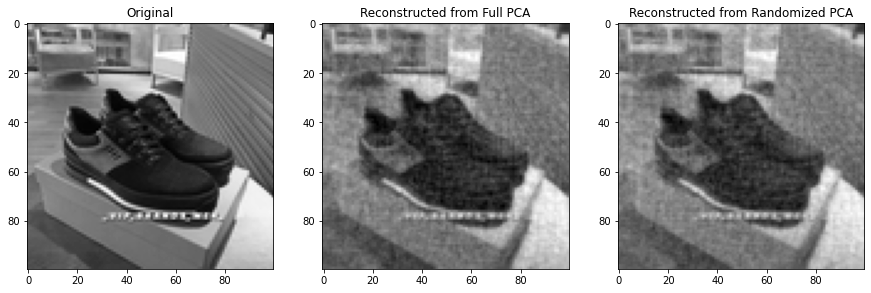

In [60]:
from skimage.metrics import structural_similarity as stsim

# From the Notebook 4
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

toRec = trainImg[0]
#For PCA
lowDimRep, reconImg = reconstruct_image(pca, toRec.reshape(1, -1))
lowDimRepRand, reconImgRand = reconstruct_image(rpca, toRec.reshape(1, -1))

#Displaying the Reconstructions
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(trainImg[0].reshape((100, 100)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)
plt.subplot(1,3,2)
plt.imshow(reconImg.reshape((100, 100)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.subplot(1,3,3)
plt.imshow(reconImgRand.reshape((100, 100)), cmap=plt.cm.gray)
plt.title('Reconstructed from Randomized PCA')
plt.grid(False)

#Doing Structural Similarity Analysis
pcaSim = []
rpcaSim = []

# Choose a fixed number here. the >2700 image set took too long. Since I shuffled the images earlier, I see no 
# problem in just taking the first 100.
simIterations = 100
for x in range(simIterations):
    lowDimRep, reconImg = reconstruct_image(pca, trainImg[x].reshape(1, -1))
    lowDimRepRand, reconImgRand = reconstruct_image(rpca, trainImg[x].reshape(1, -1))
    pcaSim.append(stsim(im1=trainImg[x].reshape((100, 100)), im2=reconImg.reshape((100, 100)), data_range = 255))
    rpcaSim.append(stsim(im1=trainImg[x].reshape((100, 100)), im2=reconImgRand.reshape((100, 100)), data_range = 255))

print("Structural Similarity of PCA vs Randomized PCA (n=", simIterations, ")")
print("PCA:\t", np.mean(pcaSim))
print("RPCA:\t", np.mean(rpcaSim))

### Feature Extraction

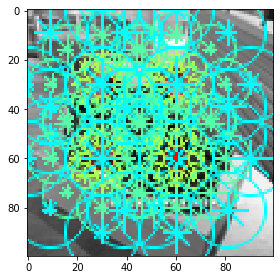

In [70]:
from skimage.feature import daisy
from skimage.io import imshow

features, img_desc = daisy(trainImg[0].reshape(100,100), 
                           step=30, 
                           radius=30, 
                           rings=3, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
imshow(img_desc)

### Classification

In [201]:
from sklearn.neighbors import KNeighborsClassifier as knc

def plot_neighbors(img, neigh, titles, h, w, n_row=3, n_col=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(3 * n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row):
        for j in range(3):
            print(j)
            plt.subplot(n_row, 3, (i * 3) + j + 1)
            plt.imshow(img[neigh[i,j]].reshape((h, w)), cmap=plt.cm.gray)
            plt.title(titles[neigh[i,j]], size=12)
            plt.xticks(())
            plt.yticks(())


nearestPCA = knc(n_neighbors=3, weights = 'uniform')
nearestPCA.fit(pcaTrainImg, trainTruth)
yRes = nearestPCA.predict(pcaTrainImg)
nearestPCA.score(pcaTrainImg, trainTruth)
neighbors = nearestPCA.kneighbors(pcaTrainImg, 3, return_distance=False)
#print(neighbors[:,0])
#print(neighbors[:,1])
#plot_gallery(trainImg[neighbors[:,0]], trainTruth[neighbors[:,0]], h=100, w=100, n_row=3, n_col=3)
#plot_gallery(trainImg[neighbors[:,1]], trainTruth[neighbors[:,0]], h=100, w=100, n_row=3, n_col=3)
#plot_neighbors(trainImg, neighbors, trainTruth, h=100, w=100)

correctNon = 0
correctFire = 0
correctFlood = 0
for (guess,truth) in zip(yRes,trainTruth):
    if guess == truth:
        if guess == 'fires':
            correctFire = correctFire + 1
        elif guess == 'flood':
            correctFlood = correctFlood + 1
        else:
            correctNon = correctNon + 1
trainTruth = np.asarray(trainTruth)
print('Fire Accuracy: ', correctFire / len(trainTruth[trainTruth == 'fires']))
print('Flood Accuracy: ', correctFlood / len(trainTruth[trainTruth == 'flood']))
print('Non-Damage Accuracy: ', correctNon / len(trainTruth[trainTruth == 'non_damage']))
yRes

Fire Accuracy:  0.6579925650557621
Flood Accuracy:  0.5652173913043478
Non-Damage Accuracy:  0.8854073410922113


array(['non_damage', 'non_damage', 'non_damage', ..., 'non_damage',
       'non_damage', 'non_damage'], dtype='<U10')

## Exceptional Work